## Kaggle Digit Recognizer

This exercise looks at the use of the PCA to speed up a machine learning algorithm by reducing the number of variables considered. We attempt to use a PCA to reduce the number of variables we consider in the algorithm while maintaining the level of prediction accuracy.

In this case, we use a random forest classifier to predict a number from a digitized handwritten number. We start with a training set of 42,000 handwritten numbers which have been labelled. The Exploratory data analysis identifies that the numbers are not evenly distributed, with more of the digits 1, 3 and 7 and less of the digit 5. We also identify that there are a significant number of pixels where the values are 0 or 255 across all images and these can be removed from the data set. Finally we see that a PCA would be of value as the pareto curve applies to variance by pixel, which some pixels accounting for significantly more of the variance.

In the transformation, we remove 65 pixels which are completely black or white across the entire training and testing datasets. The PCA identifies that only 320 variables are needed to account for 95% of the variance. 

Running a random forest classifier both before and after the PCA give us the same result: an R2 score of 100 and a Kaggle score of 0.96442. This shows that we have successfully reduced the number of dimensions without impacting model accuracy. 320 of the highest variance generating variables can be used to predict as accurately as the entire dataset while significantly improving model speed.


### Load Packages

In [38]:
# Basic dataframe, array, and math stuff
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport as pp

#Basic Operating System Stuff
import os
import random #random seed generator

#Timer
from timeit import default_timer as timer #import a timer

# mnist
from mnist.loader import MNIST

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package

#Scikit learn
from sklearn.preprocessing import StandardScaler # used for variable scaling data
from sklearn.preprocessing import MinMaxScaler as Scaler # used for variable scaling data

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import tree

from sklearn.model_selection import RandomizedSearchCV as srch

#Graphing
import seaborn as sns
import pydot  #For model plotting
from IPython.display import SVG #For model plotting
from IPython.display import display #For model plotting
import matplotlib.pyplot as plt #plotting
import matplotlib as mpl #image save
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import image as mpimg
from matplotlib.pyplot import imshow #Show images
from PIL import Image #Another image utility
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Set rows and columnns for display so that we can see more than just 10 rows from print
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

# Set seaborn charts to seaborn default settings
sns.set()

### Load Data

In [5]:
train = pd.read_csv('../digit/train.csv')
test = pd.read_csv('../digit/test.csv')

## Exploratory Data Analysis

The EDA identifies that the first column in the data set is a label showing the number, and that there are 784 columns showing the intensity of the colour in a single pixel. Pixels are labelled pixel0 to pixel 783. 

There are 42000 rows of data, all with a numeric data type, so there are no categorical values in this analysis. There are now null rows in the data, so there is no need for imputation.

An interesting finding is that the numbers are not evenly distributed. It appears that there are significantly more 1s, 3s and 7s then there are 5s.

A look at the sample of numbers shows that some pixels (for example in the corners) may be black or white every digit. 

A review of the description of the data shows that there are pixels where the min, mean and max are 0 or 255, showing the pixels that are either completely black or completely white in every digit image. These pixels can be removed from the analysis.



### Copy train data to avoid modifying it for EDA

In [6]:
df = train.copy()
df_test=test.copy()

### Overview of data
First column shows number, other 784 columns show pixel colour depth

In [7]:
display(df.head())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,...,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Shape of data
Training data: 1 label column, 784 pixel columns, 42000 numbers
Testing data: 784 pixel columns, 28000 numbers

In [8]:
display(df.shape)

(42000, 785)

In [9]:
display(df_test.shape)

(28000, 784)

### Data info
Data shows 1 label entry, and other entries are listed to pixel 783

In [10]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


None

### Check for Null Values
No Null Values

In [11]:
#NaN values in the dataset ?

nan = df.isnull().sum()
print(nan[nan != 0])

Series([], dtype: int64)


### Look at distribution of numbers
Looks like the distribution set is significantly biased towards 1, 3 and 7 and against 5.

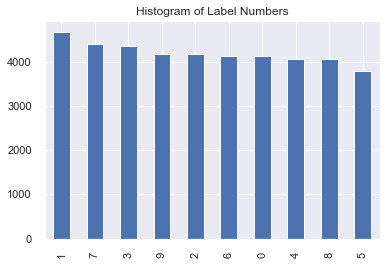

In [12]:
#Distribution of the digits in the dataset
Digit_Dist = df['label'].value_counts().plot(kind='bar')
plt.title('Histogram of Label Numbers')
plt.show()


### Show sample of handwritten digit images
Show image for 24 digits and the corresponding label

Handwritten picked-up digits:  [0 3 3 4 2 4 1 2 5 9 5 1 9 9 1 5 5 8 8 4 8 3 3 8]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



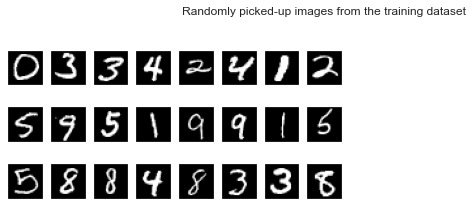

''

In [13]:
# Displays a designated number of handwritten digit images
# source: https://www.kaggle.com/damienbeneschi/mnist-eda-preprocessing-classifiers

def display_digits(N):
    """Picks-up randomly N images within the 
    train dataset between 0 and 41999 and displays the images
    with 4 images/row"""
    
    images = np.random.randint(low=0, high=42001, size=N).tolist()
  
    
    subset_images = df.iloc[images,:]
    subset_images.index = range(1, N+1)
    print("Handwritten picked-up digits: ", subset_images['label'].values)
    subset_images.drop(columns=['label'], inplace=True)

    for i, row in subset_images.iterrows():
        plt.subplot((N//8)+1, 8, i)
        pixels = row.values.reshape((28,28))
        plt.imshow(pixels, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.title('Randomly picked-up images from the training dataset', y=5)
    plt.show()

    return ""

display_digits(24)

### Look at pixel intensities
A lot of pixels where the data is 0 across all 42000 images. We could drop these pixels.
Also, it appears maximum intensity is 255

In [14]:
#Analyse the pixels intensities
subset_pixels = df.iloc[:, 1:]
subset_pixels.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,...,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,0.174119,0.191310,0.190595,0.196048,0.171357,0.164476,0.151714,0.105310,0.060786,0.045071,0.015405,...,0.503095,1.146333,2.161786,3.243452,4.637214,5.979500,6.605095,6.443595,5.681095,4.656952,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,5.810949,5.995212,5.910242,6.024478,5.726352,5.515774,5.436431,4.478486,3.457538,2.933291,1.598329,...,9.617457,14.813496,20.680863,25.122322,30.096075,34.136445,35.807719,35.121494,33.020299,29.711767,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

### Would PCA be of any benefit?

The charts below show the attribution of variance to each predictor (pixel). As we can see from the charts, a small number of the predictors account for a large part of the variance, so a PCA which would reduce the number of attributes while focusing on maximizing the variance can speed up the processing while maintianing model relevance.

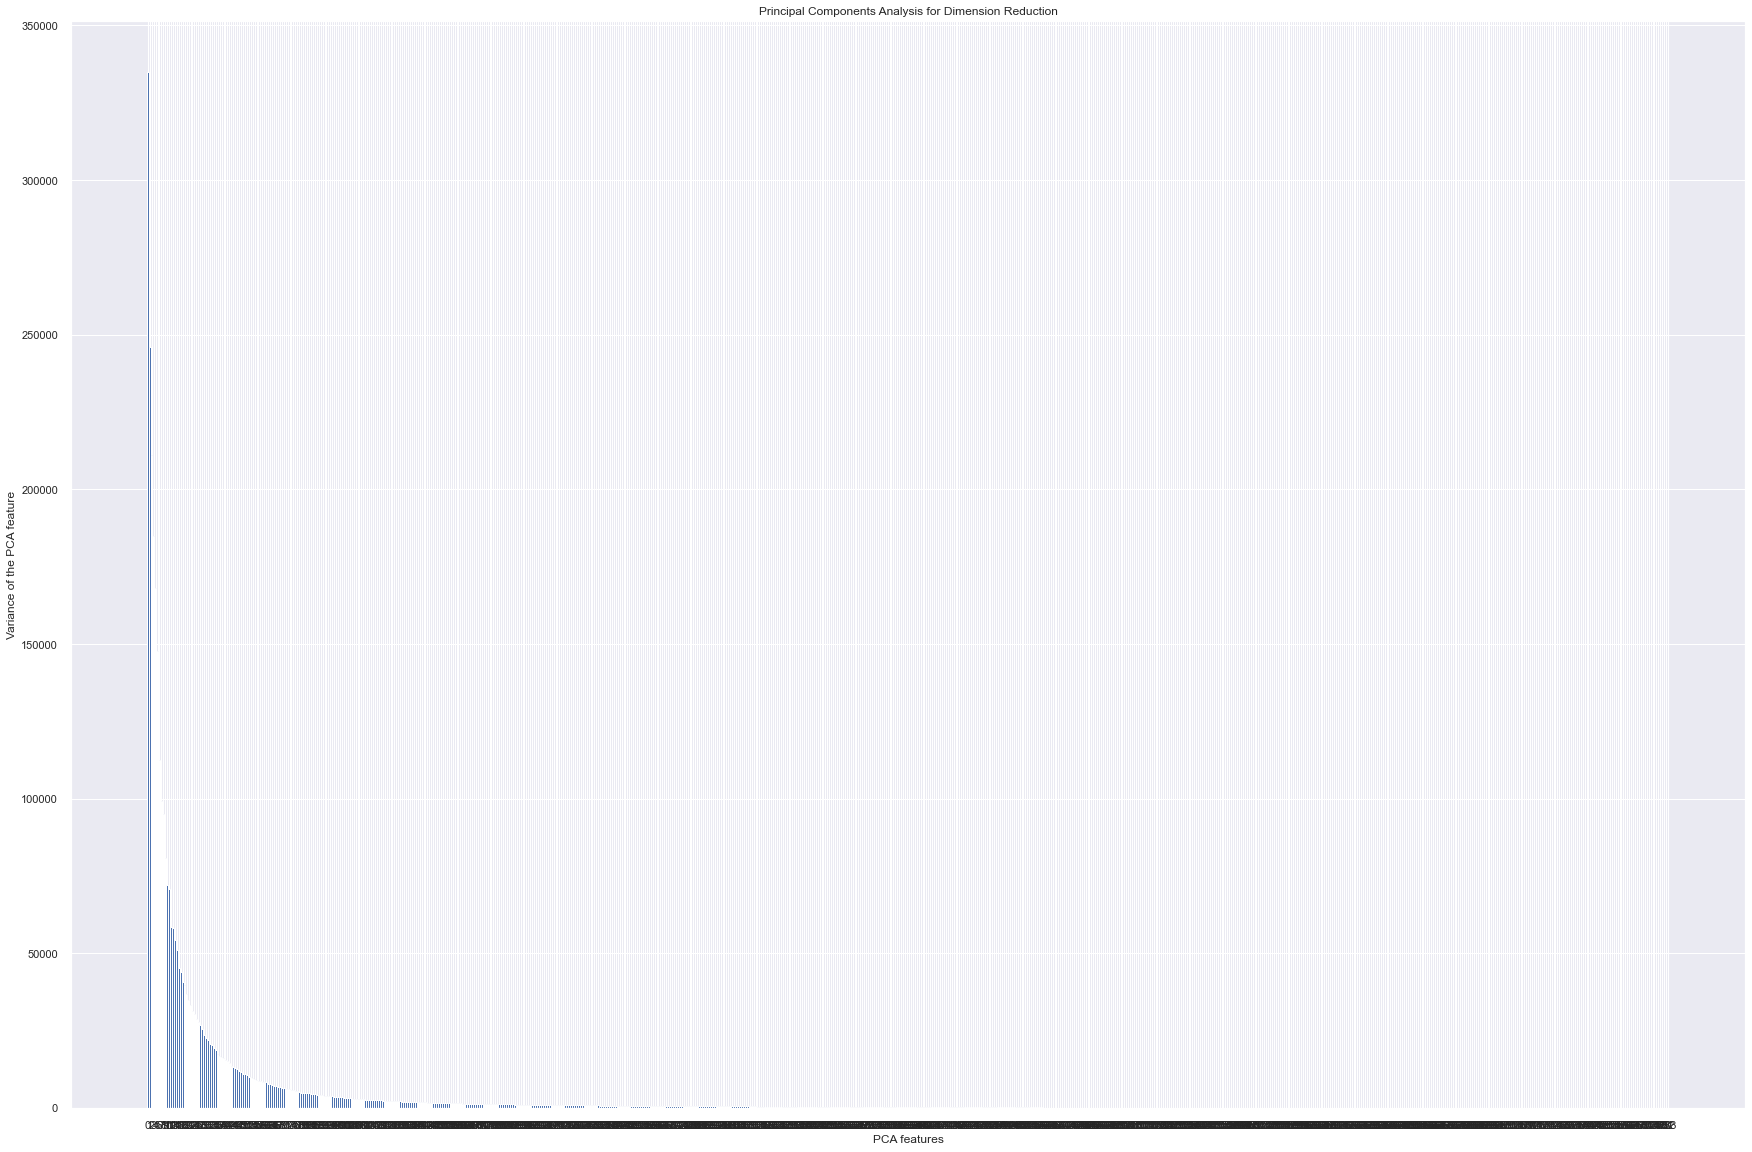

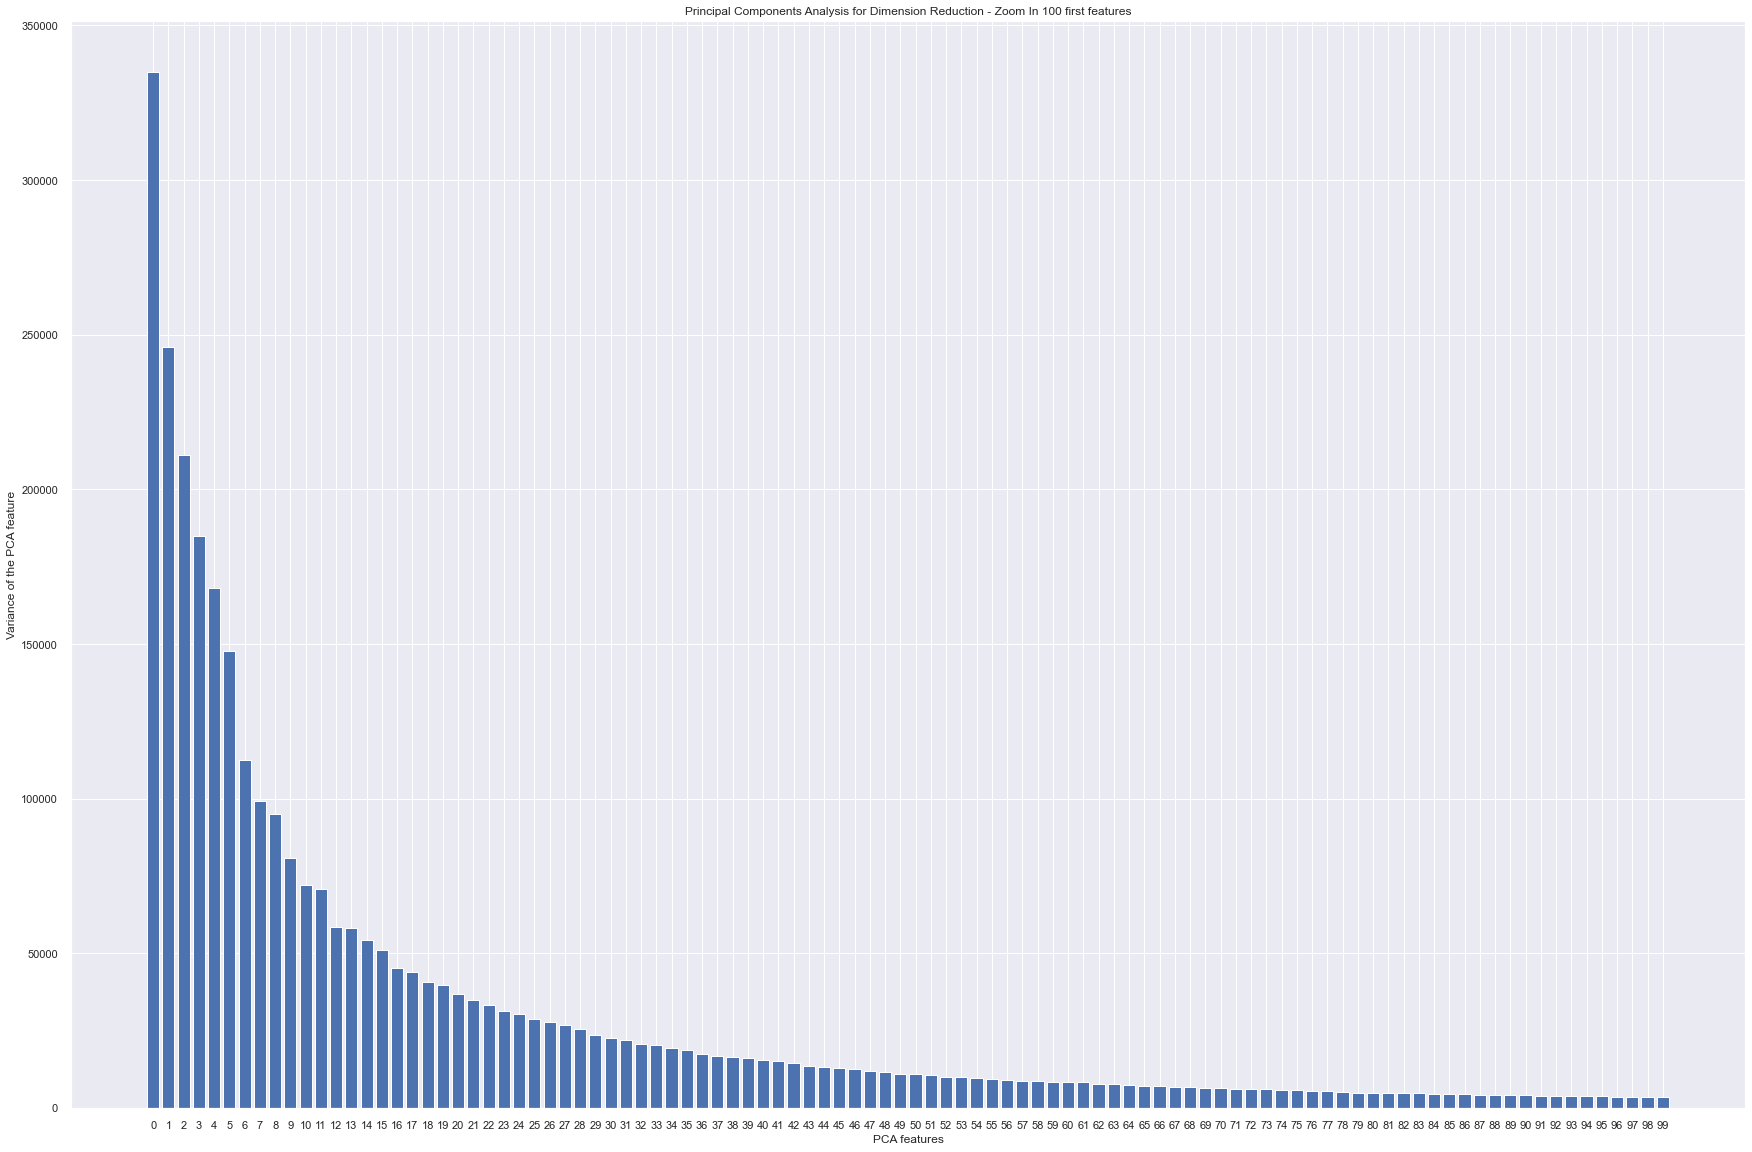

In [15]:
# Model source: https://www.kaggle.com/damienbeneschi/mnist-eda-preprocessing-classifiers

#PCA model
images = df.loc[:,'pixel0':'pixel783']
pca = PCA()
pca.fit(images)

#PCA features variance visualization
pca_features = range(pca.n_components_)
_ = plt.figure(figsize=(30,20))
_ = plt.bar(pca_features, pca.explained_variance_)
_ = plt.xticks(pca_features)
_ = plt.title('Principal Components Analysis for Dimension Reduction')
_ = plt.xlabel('PCA features')
_ = plt.ylabel('Variance of the PCA feature')
#_ = plt.savefig('visualizations/PCA features variance.png')
plt.show()

#PCA features variance visualization - ZOOM in
l= 100
x = range(l)
_ = plt.figure(figsize=(30,20))
_ = plt.bar(x, pca.explained_variance_[:l])
_ = plt.xticks(x)
_ = plt.title('Principal Components Analysis for Dimension Reduction - Zoom In {} first features'.format(l))
_ = plt.xlabel('PCA features')
_ = plt.ylabel('Variance of the PCA feature')
#_ = plt.savefig('visualizations/PCA features variance_zoom.png')
plt.show()

## Data Transformation

The first step of the data transformation was to remove the pixels which have the same intensity across all records. In this step, we remove 65 pixels which are completely black or white across the entire training and testing datasets. 

### Join train and test data for transformation

In [16]:
# Transform all the predictor features
# This excludes the saleprice (which is after salecondition)

df_train = train.copy()
df_test=test.copy()

all_data = pd.concat((df_train.loc[:,'pixel0':'pixel783'],
                      df_test.loc[:,'pixel0':'pixel783']))

### Remove pixels which are all black or all white in every image

In [17]:
# This is a program that will look into a dataframe and remove all the pixels which are black (0) or white(255) in 
# every single row and the give a list of the pixels removed.
# It identifies 76 pixels, which reduces the dataset by almost 10%.
# source: https://www.kaggle.com/damienbeneschi/mnist-eda-preprocessing-classifiers


def remove_constant_pixels(pixels_df):
    """Removes from the images the pixels that have a constant intensity value,
    either always black (0) or white (255)
    Returns the cleared dataset & the list of the removed pixels (columns)"""

    #Remove the pixels that are always black to compute faster
    changing_pixels_df = pixels_df.loc[:]
    dropped_pixels_b = []

    #Pixels with max value =0 are pixels that never change
    for col in pixels_df:
        if changing_pixels_df[col].max() == 0:
            changing_pixels_df.drop(columns=[col], inplace=True)
            dropped_pixels_b.append(col)
    print("Constantly black pixels that have been dropped: {}".format(dropped_pixels_b))


    #Same with pixels with min=255 (white pixels)
    dropped_pixels_w = []
    for col in changing_pixels_df:
        if changing_pixels_df[col].min() == 255:
            changing_pixels_df.drop(columns=[col], inplace=True)
            dropped_pixel_w.append(col)
    print("\n Constantly white pixels that have been dropped: {}".format(dropped_pixels_b))

    print(changing_pixels_df.head())
    print("Remaining pixels: {}".format(len(changing_pixels_df.columns)))
    print("Pixels removed: {}".format(784-len(changing_pixels_df.columns)))
    
    return changing_pixels_df, dropped_pixels_b + dropped_pixels_w

In [18]:
# Run the pixel removal code on dataframe

# Use this line if you want to pull the training dataset and just remove the label. In this program we use the all_data 
# dataframe which already has the labels column removed.
# train_X_df = pd.read_csv('../digit/train.csv').drop(columns=['label'])

train_mod_X_df, dropped_pixels = remove_constant_pixels(all_data)

Constantly black pixels that have been dropped: ['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel111', 'pixel112', 'pixel140', 'pixel168', 'pixel476', 'pixel560', 'pixel644', 'pixel671', 'pixel672', 'pixel673', 'pixel699', 'pixel700', 'pixel701', 'pixel727', 'pixel728', 'pixel729', 'pixel730', 'pixel754', 'pixel755', 'pixel756', 'pixel757', 'pixel758', 'pixel759', 'pixel780', 'pixel781', 'pixel782', 'pixel783']

 Constantly white pixels that have been dropped: ['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'p

## Run Analysis

Running a random forest classifier both before and after the PCA give us the same result: an R2 score of 100 and a Kaggle score of 0.96442. This shows that we have successfully reduced the number of dimensions without impacting model accuracy. 320 of the highest variance generating variables can be used to predict as accurately as the entire dataset while significantly improving model speed.

We also ran the K nearest neighbours and decision tree classifiers but they provided inferior results to the random forest classifier.


### Create Training and test data

In [19]:
# Create data matrices

X_train = train_mod_X_df[:df_train.shape[0]]
X_test = train_mod_X_df[df_train.shape[0]:]
y_train = df_train.label

X_train.to_csv('../digit/X_train.csv')
X_test.to_csv('../digit/X_test.csv')
y_train.to_csv('../digit/y_train.csv')

In [20]:
# Check to make sure data is correct shape
# Train should have 42,000 rows and Test should have 28000 rows
# Number of columns should match "remaining pixels" from the pixel removal
# y_train should have 42,000 rows and 1 column

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)

(42000, 719)

(28000, 719)

(42000,)

In [21]:
# Prepare images and labels arrays

images = X_train
labels = y_train
images_test = X_test
print(images.shape)

(42000, 719)


### Random Forest Classifier before PCA
Model gives us a 100 R2 score and 0.96442 on Kaggle cross validation.

In [22]:
# Run Random Forest Classifier before PCA

rf=rfc(random_state=1234, n_jobs=-1, n_estimators=100).fit(images,labels)
rf.score(images,labels)
acc_rf = round(rf.score(images,labels) * 100, 2)
print(acc_rf)

100.0


In [23]:
# Generate kaggle output from Random Forest Classifier
rf_Pred=(rf.predict(images_test))

display(rf_Pred)

df_rf_Pred=pd.DataFrame(rf_Pred)
df_rf_Pred.to_csv('../digit/rf_Pred.csv')

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

### Scale Data for PCA
PCA performs best with normalized data sets, so we will normalize the data set before applying PCA. (https://www.researchgate.net/post/Is_it_necessary_to_normalize_data_before_performing_principle_component_analysis)

In [24]:
ss = StandardScaler()
images = ss.fit_transform(images)
images_test = ss.transform(images_test)

### Apply PCA
Instruction source
https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/

The explained variance shows the contribution of variance each of the selected components contributes, up to the specified variance, in this case 95% of the variance (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

The array output shows that 320 variables are needed to hit 95% of the variance.

In [26]:
# Apply PCA

pca=PCA(.95)
images = pca.fit_transform(images)
images_test = pca.transform(images_test)

In [28]:
# Generate Variance ratio array
explained_variance = pca.explained_variance_ratio_
display(explained_variance)

array([0.05747953, 0.04111691, 0.03782867, 0.02939862, 0.02556439,
       0.02229844, 0.01952552, 0.01771605, 0.0156266 , 0.01424956,
       0.01361009, 0.01222541, 0.01135736, 0.0111309 , 0.01050311,
       0.01012326, 0.00951303, 0.00934514, 0.00907259, 0.00885327,
       0.00838907, 0.00812027, 0.00775161, 0.00752312, 0.0072769 ,
       0.00698756, 0.00690455, 0.00664924, 0.00630675, 0.00616301,
       0.00610922, 0.00597037, 0.00577284, 0.00573682, 0.00564822,
       0.00546322, 0.0053943 , 0.00524361, 0.00504843, 0.0048853 ,
       0.00482244, 0.00475901, 0.00460008, 0.00457629, 0.00449584,
       0.00446722, 0.00443837, 0.00436837, 0.00432713, 0.00427027,
       0.00419269, 0.0041218 , 0.00402461, 0.00399434, 0.00394891,
       0.00390805, 0.00379899, 0.00372454, 0.00368413, 0.00365723,
       0.00353278, 0.00351088, 0.00345414, 0.00341394, 0.00337784,
       0.00336477, 0.0033171 , 0.00329725, 0.00320016, 0.00316776,
       0.00312695, 0.00311861, 0.00308212, 0.00303276, 0.00301

### Fine tune random forest 
Result shows we should run with criterion entropy with n_estimators 200

In [31]:
rf=rfc(random_state=1234, n_jobs=-1, n_estimators=100).fit(images,labels)
rf.score(images,labels)
print(rfc().get_params())
criterion, n_estimators=['entropy','gini'], [100,150,200]
random_grid = {'criterion':criterion,'n_estimators': n_estimators}
srch(estimator=rf, param_distributions=random_grid, 
                             n_iter=4,cv=2,verbose=2,random_state=12,n_jobs=-1).fit(images,labels).best_params_

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  3.0min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.3min finished


{'n_estimators': 200, 'criterion': 'entropy'}

### Run Random Forest after fine tuning and PCA

We end up with the same result as running the Random Forest before PCA but with faster processing. The increased performace with no accuracy loss shows this to attempt be a success.

In [32]:
rf=rfc(random_state=1234, n_jobs=-1, n_estimators=200, criterion='entropy').fit(images,labels)
rf.score(images,labels)
acc_rf = round(rf.score(images,labels) * 100, 2)
print(acc_rf)

100.0


In [33]:
# Generate kaggle output from Random Forest Classifier
rf_Pred_2=(rf.predict(images_test))

display(rf_Pred)

df_rf_Pred_2=pd.DataFrame(rf_Pred_2)
df_rf_Pred.to_csv('../digit/rf_Pred_2.csv')

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

### Use K Nearest Neighbours

This took over an hour to run, and ended up with a lowe kaggle score of 0.94314

In [36]:
knn=KNN(3).fit(images,labels)
knn.score(images,labels)
acc_knn = round(knn.score(images,labels) * 100, 2)
print(acc_knn)

97.18


In [37]:
# Generate kaggle output from K Nearest Neighbours
knn_Pred=(knn.predict(images_test))

display(knn_Pred)

df_knn_Pred=pd.DataFrame(knn_Pred)
df_knn_Pred.to_csv('../digit/knn_Pred.csv')

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

### Fine tune  K Nearest Neighbours
Do not run takes too long until more computing power is available

In [ ]:
# knn=knn(n_neighbors=3).fit(images,labels)
# knn.score(images,labels)
# print(rfc().get_params())
# algorithm, n_neighbors=[‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’], [3,5,7]
# random_grid = {'algorithm':algorithm,'n_neighbors': n_neighbors}
# srch(estimator=rf, param_distributions=random_grid, 
                             n_iter=4,cv=2,verbose=2,random_state=12,n_jobs=-1).fit(images,labels).best_params_

### Use Decision Tree Classifier

This generated a significantly score of 0.81385 even though it had the same R2 as the random forest and took about the same time to run as the random forest. This attempt was certainly inferiro to the random forest.

In [39]:
tree = tree.DecisionTreeClassifier().fit(images,labels)
tree.score(images,labels)
acc_tree = round(tree.score(images,labels) * 100, 2)
print(acc_tree)

100.0


In [40]:
# Generate kaggle output from Decision tree classifier
tree_Pred=(tree.predict(images_test))

display(tree_Pred)

df_tree_Pred=pd.DataFrame(tree_Pred)
df_tree_Pred.to_csv('../digit/tree_Pred.csv')

array([2, 0, 2, ..., 3, 9, 2], dtype=int64)